            +--------------------+     +-----------------+
Image Input →→ CNN (ResNet18) →→ |     |                 |
            +--------------------+     |                 |
                                       | Concatenation →→ MLP →→ 5-class Output
            +--------------------+     |                 |
Text Input  →→ TF-IDF Vectorizer →→    |                 |
            +--------------------+     +-----------------+


In [1]:
# Basic library imports
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report, confusion_matrix
import random
import copy 
import regex as re 
from sklearn.manifold import TSNE


In [2]:
# Check if GPU is available (i have used RTx 3050)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [3]:
# Define the path to the images and OCR data
image_dir = "../data/images"
ocr_dir = "../data/ocr"

# Check if directories exist
assert os.path.exists(image_dir), f"Image directory not found: {image_dir}"
assert os.path.exists(ocr_dir), f"OCR directory not found: {ocr_dir}"
print(f"[INFO] Data directories found.\nImages: {image_dir}\nOCRs: {ocr_dir}")



[INFO] Data directories found.
Images: ../data/images
OCRs: ../data/ocr


In [4]:
class ImageOCRDataset(Dataset):
    def __init__(self, image_dir, ocr_dir, classes):
        self.image_dir = image_dir
        self.ocr_dir = ocr_dir
        self.classes = classes
        self.image_paths = []
        self.ocr_texts = []
        self.labels = []
        
        print("Initializing dataset...")
        # Reading all images and corresponding OCR text files
        for label in classes:
            image_paths = glob.glob(os.path.join(image_dir, label, "*.TIF"))
            print(f"Found {len(image_paths)} images for class '{label}'")
            for image_path in image_paths:
                ocr_path = image_path.replace(image_dir, ocr_dir).replace(".TIF", ".TIF.txt")
                with open(ocr_path, 'r') as f:
                    ocr_text = f.read()
                self.image_paths.append(image_path)
                self.ocr_texts.append(ocr_text)
                self.labels.append(label)
        
        print(f"Total samples loaded: {len(self.image_paths)}")
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        print(f"Label encoding complete. Classes: {self.label_encoder.classes_}")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Loading and preprocess image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = image.resize((224, 224))  # Resizing to match ResNet input size
        image = np.array(image) / 255.0  # Normalize image (0-1)
        image = torch.tensor(image).permute(2, 0, 1).float()  # Convert to tensor and change channel order
        
        # Ensure image tensor is of type float32
        image = image.to(torch.float32) 
        
        # Get OCR text and vectorize
        ocr_text = self.ocr_texts[idx]
        ocr_vector = self.ocr_tfidf.transform([ocr_text]).toarray().squeeze()  # Transform into TF-IDF vector
        
        # Ensure text tensor is of type float32
        ocr_vector = torch.tensor(ocr_vector, dtype=torch.float32)
        
        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return image, ocr_vector, label
    
    def set_tfidf(self, ocr_texts):
        print("Fitting TF-IDF vectorizer on OCR texts...")
        # Initialize TF-IDF vectorizer and fit on OCR text data
        self.ocr_tfidf = TfidfVectorizer(max_features=1000)  # Limit features for simplicity
        self.ocr_tfidf.fit(ocr_texts)
        print(f"TF-IDF vocabulary size: {len(self.ocr_tfidf.vocabulary_)}")

# Get the class labels (assumed as subfolders under the "images" directory)
classes = os.listdir(image_dir)
print(f"Classes found: {classes}")

# Initialize dataset
dataset = ImageOCRDataset(image_dir, ocr_dir, classes)
dataset.set_tfidf(dataset.ocr_texts)
print("Dataset ready for use.")


Classes found: ['9', '0', '6', '4', '2']
Initializing dataset...
Found 500 images for class '9'
Found 500 images for class '0'
Found 500 images for class '6'
Found 500 images for class '4'
Found 500 images for class '2'
Total samples loaded: 2500
Label encoding complete. Classes: ['0' '2' '4' '6' '9']
Fitting TF-IDF vectorizer on OCR texts...
TF-IDF vocabulary size: 1000
Dataset ready for use.


In [5]:
# Split into train/val/test (70/15/15)
print("Splitting dataset into train, validation, and test sets...")

train_idx, temp_idx = train_test_split(
    np.arange(len(dataset)), 
    test_size=0.3, 
    stratify=dataset.labels, 
    random_state=42
)
print(f"Training samples: {len(train_idx)}")

val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.5, 
    stratify=np.array(dataset.labels)[temp_idx], 
    random_state=42
)
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_idx)}")

# Create dataset subsets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

print("Subsets created.")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Dataloaders initialized.")
print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")


Splitting dataset into train, validation, and test sets...
Training samples: 1750
Validation samples: 375
Test samples: 375
Subsets created.
Dataloaders initialized.
Train loader batches: 55
Validation loader batches: 12
Test loader batches: 12


In [6]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes=5, text_feature_size=1000, dropout_prob=0.2):
        super(MultiModalClassifier, self).__init__()
        
        # Image branch: ResNet18 pre-trained model
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer to get feature embeddings
        
        # Text branch: Fully connected layer for OCR features (TF-IDF)
        self.text_fc = nn.Linear(text_feature_size, 128)
        
        # Concatenation of image and text features
        self.fc1 = nn.Linear(512 + 128, 256)  # 512 from ResNet, 128 from OCR text
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout to prevent overfitting

        self.fc2 = nn.Linear(256, num_classes)  # Final classification layer
    
    def forward(self, image, text):
        # Ensure both image and text are float32
        image = image.to(torch.float32)  # Ensure image is float32
        text = text.to(torch.float32)    # Ensure text is float32
        
        # Forward pass through the image branch
        image_features = self.resnet(image)  # Extract features from ResNet
        
        # Forward pass through the text branch
        text_features = torch.relu(self.text_fc(text))  # Extract features from OCR text
        
        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # Classification head
        x = torch.relu(self.fc1(combined_features))
        x = self.dropout(x) # Apply dropout during training
        x = self.fc2(x)
        return x


In [7]:
# Initialize the model and move it to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier(num_classes=len(classes), text_feature_size=1000).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/kailash/Programming/Smart_data_solutions/doc_classifier_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kailash/Programming/Smart_data_solutions/doc_classifier_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:


num_epochs = 50
patience = 3
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    train_loss = running_loss / len(train_loader)

    #  Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, texts, labels in val_loader:
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)
            outputs = model(images, texts)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total * 100
    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model_v4.pth')
        print(" ##### Best model updated and saved ######.")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f" No improvement for {epochs_without_improvement} epoch(s).")

    #  Early stopping
    if epochs_without_improvement >= patience:
        print(f" Early stopping triggered after {patience} epochs without improvement.")
        break

Epoch 1/50: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch 1 => Train Loss: 0.7790, Train Acc: 72.74%, Val Acc: 70.13%
 ##### Best model updated and saved ######.


Epoch 2/50: 100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


Epoch 2 => Train Loss: 0.4990, Train Acc: 83.43%, Val Acc: 82.93%
 ##### Best model updated and saved ######.


Epoch 3/50: 100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


Epoch 3 => Train Loss: 0.3599, Train Acc: 88.29%, Val Acc: 88.00%
 ##### Best model updated and saved ######.


Epoch 4/50: 100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


Epoch 4 => Train Loss: 0.2103, Train Acc: 93.54%, Val Acc: 82.13%
 No improvement for 1 epoch(s).


Epoch 5/50: 100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch 5 => Train Loss: 0.1737, Train Acc: 93.66%, Val Acc: 89.87%
 ##### Best model updated and saved ######.


Epoch 6/50: 100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


Epoch 6 => Train Loss: 0.1252, Train Acc: 96.34%, Val Acc: 86.67%
 No improvement for 1 epoch(s).


Epoch 7/50: 100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


Epoch 7 => Train Loss: 0.0702, Train Acc: 97.83%, Val Acc: 89.60%
 No improvement for 2 epoch(s).


Epoch 8/50: 100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


Epoch 8 => Train Loss: 0.0522, Train Acc: 98.46%, Val Acc: 89.33%
 No improvement for 3 epoch(s).
 Early stopping triggered after 3 epochs without improvement.


In [9]:
# Load best model
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [10]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, texts, labels in test_loader:
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
        
        outputs = model(images, texts)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification report
report = classification_report(all_labels, all_preds, digits=2)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print nicely
print("\n" + report)
print("Confusion Matrix:")
print(conf_matrix)

# Save to file
metrics_file = "../reports/classification_statistics.txt"
with open(metrics_file, 'w') as f:
    f.write(report)
    f.write("\nConfusion Matrix:\n")
    np.savetxt(f, conf_matrix, fmt='%d')

print(f"Classification statistics saved to {metrics_file}")

Test Accuracy: 88.00%

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        75
           1       0.91      0.93      0.92        75
           2       0.81      0.88      0.85        75
           3       0.95      0.96      0.95        75
           4       0.88      0.69      0.78        75

    accuracy                           0.88       375
   macro avg       0.88      0.88      0.88       375
weighted avg       0.88      0.88      0.88       375

Confusion Matrix:
[[70  2  1  1  1]
 [ 4 70  1  0  0]
 [ 3  3 66  0  3]
 [ 0  0  0 72  3]
 [ 5  2 13  3 52]]
Classification statistics saved to ../reports/classification_statistics.txt


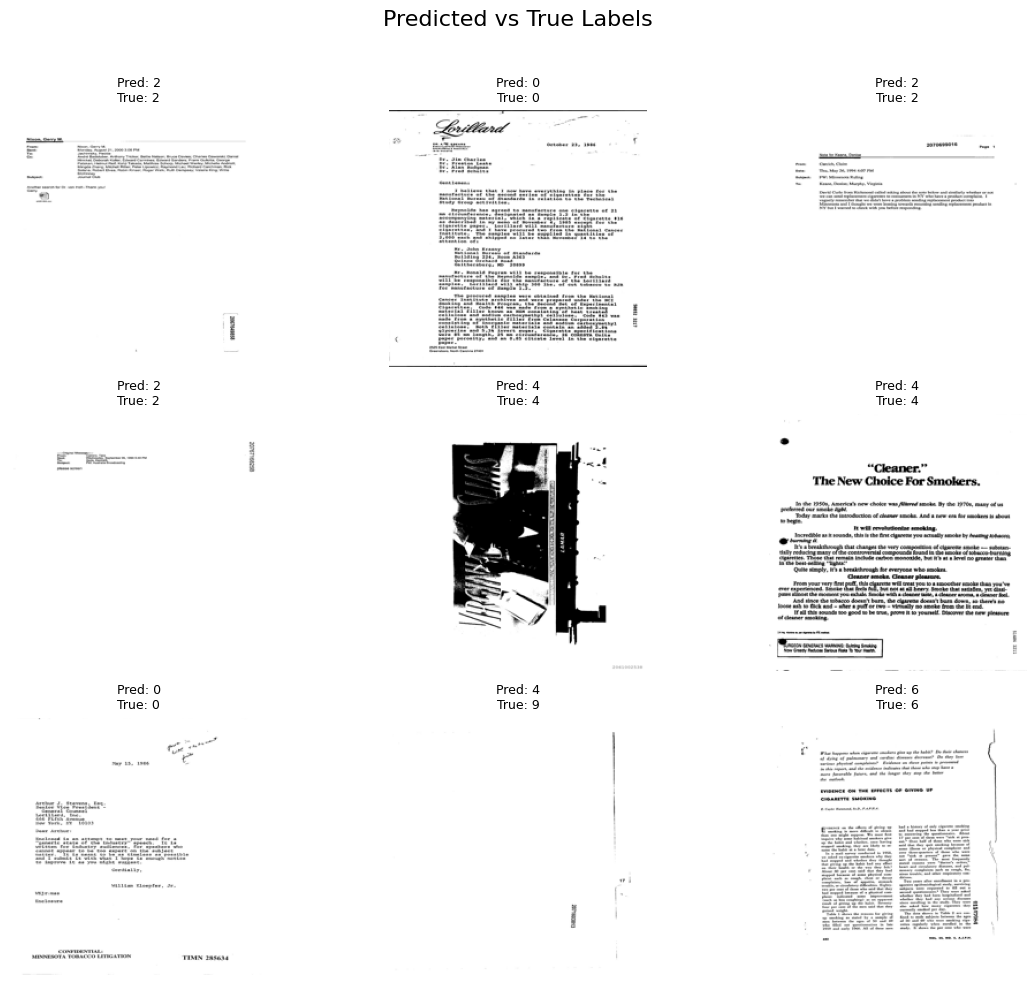

In [11]:

# Get a batch of test data
sample_images, sample_texts, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device)
sample_texts = sample_texts.to(device)
sample_labels = sample_labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(sample_images, sample_texts)
    _, predicted = torch.max(outputs, 1)

# Set number of images to visualize
num_images = 9  # You can change this to any square number (4, 9, 16, etc.)
rows = cols = int(num_images ** 0.5)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
fig.suptitle("Predicted vs True Labels", fontsize=16)

for i in range(num_images):
    ax = axes[i // cols, i % cols]
    img = sample_images[i].cpu().permute(1, 2, 0)
    pred_label = dataset.label_encoder.inverse_transform([predicted[i].item()])[0]
    true_label = dataset.label_encoder.inverse_transform([sample_labels[i].item()])[0]

    ax.imshow(img)
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [12]:
# Saving only the model weights
torch.save(model.state_dict(), '../saved_models/best_model_weights_v4.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


In [13]:
model = MultiModalClassifier(num_classes=len(classes), text_feature_size=1000)
model.load_state_dict(torch.load('../saved_models/best_model_weights_v4.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.to(device)
model.eval()
print("Model loaded from weights.")

/home/kailash/Programming/Smart_data_solutions/doc_classifier_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kailash/Programming/Smart_data_solutions/doc_classifier_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from weights.


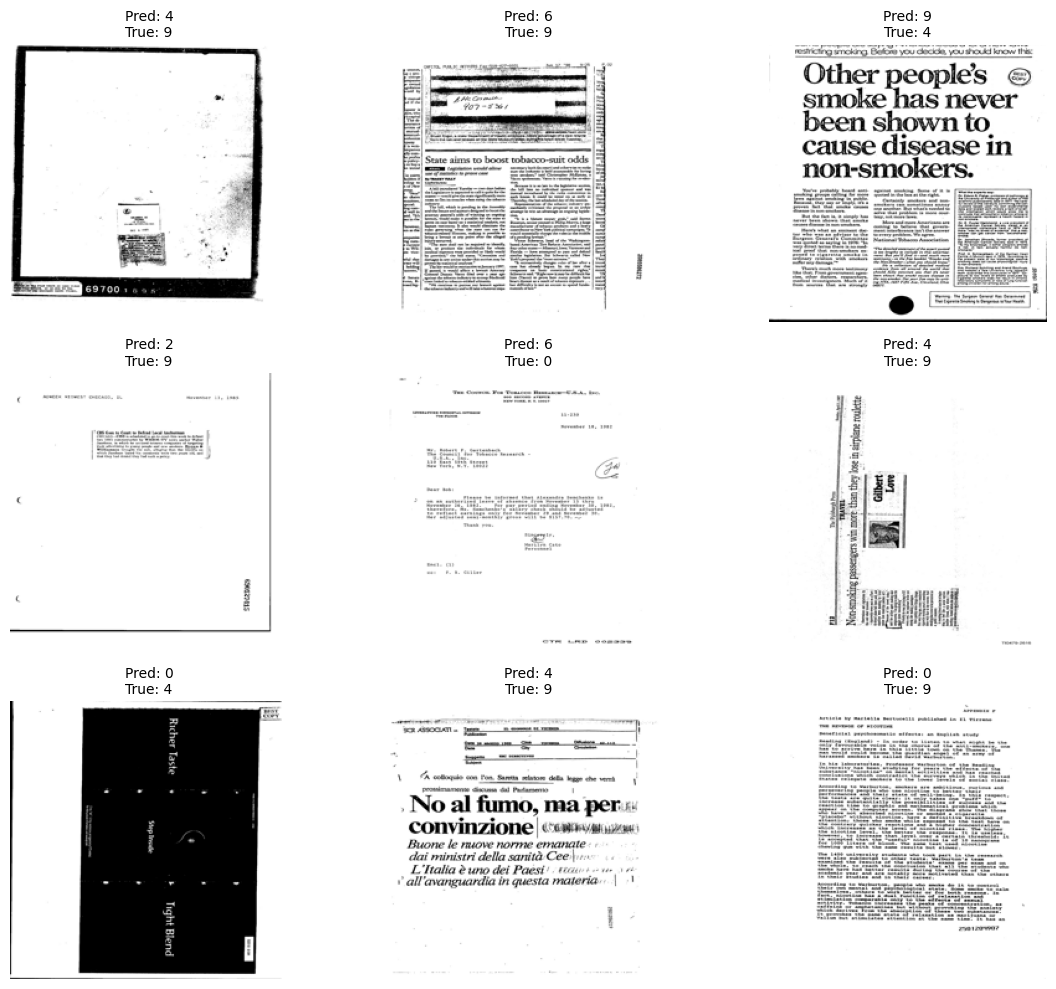

In [14]:

# Set model to evaluation mode
model.eval()

# Gather predictions and true labels from test set
all_images = []
all_texts = []
all_labels = []
all_preds = []

with torch.no_grad():
    for images, texts, labels in test_loader:
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
        
        outputs = model(images, texts)
        _, predicted = torch.max(outputs, 1)

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_preds.append(predicted.cpu())

# Concatenate all batches
all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

# Find incorrect predictions
incorrect_indices = (all_preds != all_labels).nonzero(as_tuple=True)[0]
incorrect_indices = incorrect_indices.tolist()

# Shuffle to get random ones
random.shuffle(incorrect_indices)

# Show up to 9 random incorrect predictions
num_images = min(9, len(incorrect_indices))
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i in range(num_images):
    idx = incorrect_indices[i]
    img = all_images[idx].permute(1, 2, 0)  # Convert from CHW to HWC
    true_label = dataset.label_encoder.inverse_transform([all_labels[idx].item()])[0]
    pred_label = dataset.label_encoder.inverse_transform([all_preds[idx].item()])[0]
    
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    axes[i].axis('off')

# Hide unused subplots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


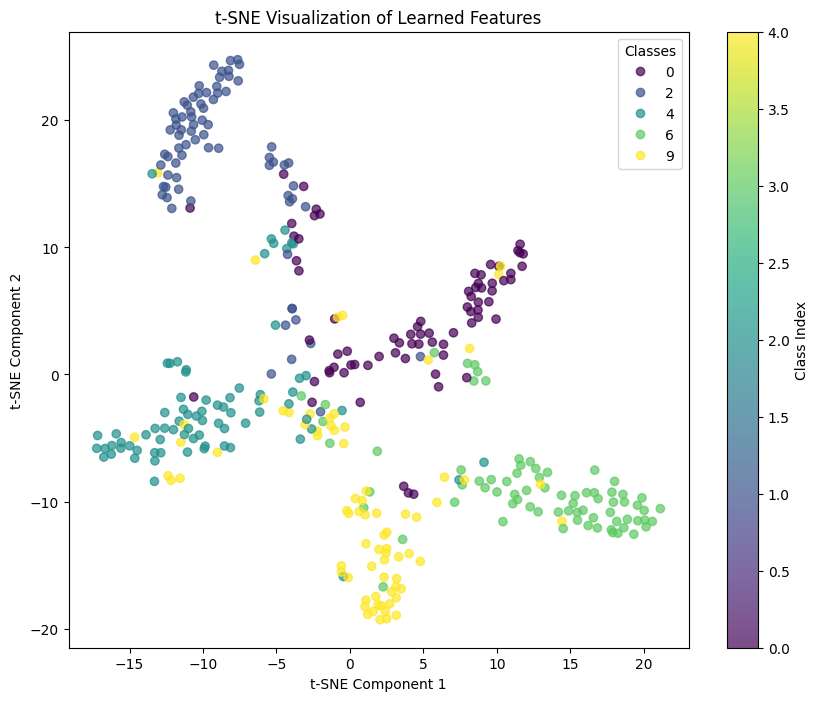

In [15]:


# Extract features for t-SNE visualization
def extract_features(model, dataloader):
    model.eval()
    image_features_list = []
    text_features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, texts, labels in dataloader:
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)
            
            # Get features from both branches of the model
            image_features = model.resnet(images)  # Get image features
            text_features = torch.relu(model.text_fc(texts))  # Get text features
            
            # Combine both image and text features
            combined_features = torch.cat((image_features, text_features), dim=1).cpu().numpy()
            
            image_features_list.append(combined_features)
            text_features_list.append(text_features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # Stack all features and labels into arrays
    image_features = np.vstack(image_features_list)
    text_features = np.vstack(text_features_list)
    labels = np.hstack(labels_list)
    
    return image_features, text_features, labels

# Get features from the test set (or validation set)
image_features, text_features, labels = extract_features(model, test_loader)

# Combine image and text features for t-SNE
combined_features = np.hstack((image_features, text_features))

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_features)

# Map labels to class names using LabelEncoder or direct mapping
class_names = dataset.label_encoder.classes_  # Assuming this is the label encoder used for training

# Plot the t-SNE results
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)

# Add color bar to indicate the class index
plt.colorbar(scatter, label='Class Index')

# Add a title and labels
plt.title('t-SNE Visualization of Learned Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend with the class names
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Classes")

plt.show()
